<a href="https://colab.research.google.com/github/CCS-ZCU/pribehy-dat/blob/master/scripts/10_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCR pomocí Pythonu

K OCR lze v Pythonu použít knihovnu `pytesseract`, postavené na nástroji Tesseract. Nejprve je tudíž potřeba mít nainstallovaný Tesseract, což není triviální úloha, neboť závisí na konkrétní verzi operečního systému. Instrukce pro windows a linux je možné nalézt zde: https://github.com/UB-Mannheim/tesseract/wiki. Pro mac nám napoví např. ChatGPT. Jelikož pracuji na macu, zde nabízím příkazy k instalaci Tesseractu pomocí terminálového instalačního nástroje `brew`: 
``` 
brew install tessaract
brew install tessaract-lang
```

Pro ukázku si načteme jeden dokument z projektu scriptum.cz, který neprošel OCR analýzou:

In [1]:
#!pip install PyMuPDF
import fitz
import requests
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import cv2
import matplotlib.patches as patches
import re
from bs4 import BeautifulSoup
import pandas as pd
import nltk

In [2]:
url = "https://scriptum.cz/soubory/scriptum/svedectvi/svedectvi_1966_29.pdf" # "https://scriptum.cz/soubory/scriptum/komunikace/prazske_komunikace_1987_01.pdf"

pdf_object = io.BytesIO(requests.get(url).content)
doc = fitz.open("pdf", pdf_object.read())
doc.page_count

169

Pro potřeby testování opět vybereme jednu náhodnou stránku a vytvoříme z ní objekt obrázku.

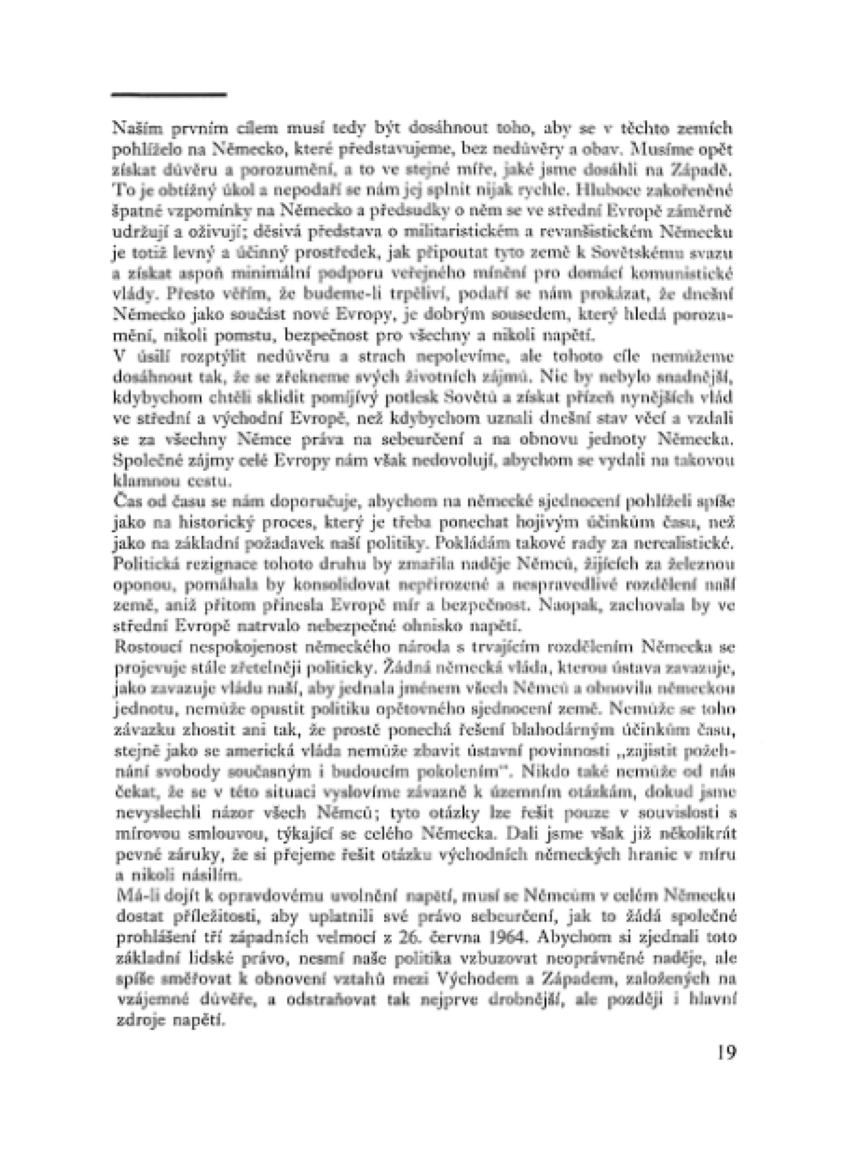

In [3]:
p = doc.load_page(20)
pix = p.get_pixmap()
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array)
ax.set_axis_off()

In [4]:
%%time
pytesseract.image_to_string(np_array, lang="ces")

CPU times: user 31.4 ms, sys: 3.78 ms, total: 35.2 ms
Wall time: 1.04 s


'Naším prvním cem muné tedy byt dosáhnout toho, sby se v těchto zemích\npohlício na Německo, ktré představujeme, bez nedůvěry a obav; Musíme opět\naka důvěru a porozumění, čo ve stejné míře, jké jeme dosáhli na Západě,\n"Toje obtížný úkol s nepodaří se nám jej plnit nk rychle, Hlboce zakořeněné\nšpatné vzpomínky na Německo  předsadky o něm se ve střední Bropě záměrně\ndržjí oživují; děsivá představa 0 mirariickém a rovonšsském Německu\nje tož levný a účšaný prostředek, jk připoutat yo země k Sovětskému sv\n(získat apod minimální podporu vetjného mínění pro domácí komunitické\nlády, Přeno věřím, že budeme-li trpěliví, podaří se nám prokázat, že dnešní\nNámecko jako součist nové Evropy, j dobrým sousedem, který ledě poru\nmění, nikoli pomotu, bezpečnost ro všehny 3 náol napětí.\nVí rozpustí nedůvěm a strach oepolevime, le tohoto cíle nemůžeme\nSosáhnout ak, že e řekneme ových Jivotich zájmů: Nic by nebylo snadněji\nkdybychom shui sklidit pomívý norka Sovětů získat přízeň nynějších vlád\n

Tuto proceduru nyní snadno aplikujeme na všechny stránky v daném dokumentu. Tato procedura však již může zabrat nezanedbatelný čas. 

In [5]:
%%time
text = ""
for p in doc:
    pix = p.get_pixmap()
    np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)
    str = pytesseract.image_to_string(np_array, lang="ces") + "[pagebreak]"
    text += str 

CPU times: user 7.9 s, sys: 1.37 s, total: 9.28 s
Wall time: 2min 25s


Podívejme se nyní na výsledný text. Z kolika sestává znaků?

In [6]:
len(text)

347226

In [7]:
text[16000:17000]

'y ve\neny, Svěská homonké miok ne\nŠkčko ke mate ne zvýlen žňoaní\nŠoněná elita votýk  vějo vět\nAv doch, kdy Jelmné opona byha\nAeprodáná. Čím atrokých pmcovních\nVarů se sní do jiné můry me pode\nore © veájné debaty 0 druhotných\nrdšémach. Jo York Zíne věk moja\n(bye žádný z úěcho pokroků neznhlá\nAovbějí jádro orměmu, kerý umožní\n\nBresnakého knihy The Svit Bor — Unity om Cenfic ve Svědeo,\n\n9\n[pagebreak](inv měn. Komunické arne ré\nmé zaumynon z vaojeje právo ro\ndom o konečnou prom o eh\nzámáných prolámuch vněnkého see\nmdo závé kone zvnit komuni.\nké srmny vadou jen nákolka ma, z\ncd kaj máte ucvát mac ako 10\nV Sem, » tmě čim Cnačov\n\ni som umýsenl neeměo z\nk oněnkých okruhů. Poem x\nŠlámkým m Danilom Je toho novým\nPlný úkonem\n\nUSA světovou obilnící\n\nJed bodýských Pier (2. edn 1965)\nJena cu spojené uy majákem\n(ánockem ab. řad drvkou zdem\nVáše vál obilný dot vokých\nŠk povoe jedu nápadní Brne\nová nl z úte uměni, ční\nn ssl dovátj a poune dvě je vk\nlo Aram o Sev Ar

Vidíme, že výsledky nejsou kdovíjaké.

# Morfologické transformace

Často se potýkáme s tím, že podkladové obrázky (skeny jednotlivých stran) nejsou v dobré kvalitě. Existuje však řada algoritmů "out-of-the-box", které mohou kvalitu obrázků změnit, např. zvýšením kontrastu.

In [8]:
p = doc.load_page(20)
pix = p.get_pixmap()
np_array = np.frombuffer(pix.samples, dtype=np.uint8).reshape(pix.height, pix.width, pix.n)

m
A l: n n

Úsilí
nj

ták přtdněji pick,
vane vládu naš, by jednala jí ore rev Něm a bav něne k
ka oněm zpímocní země Nemáte lm

|


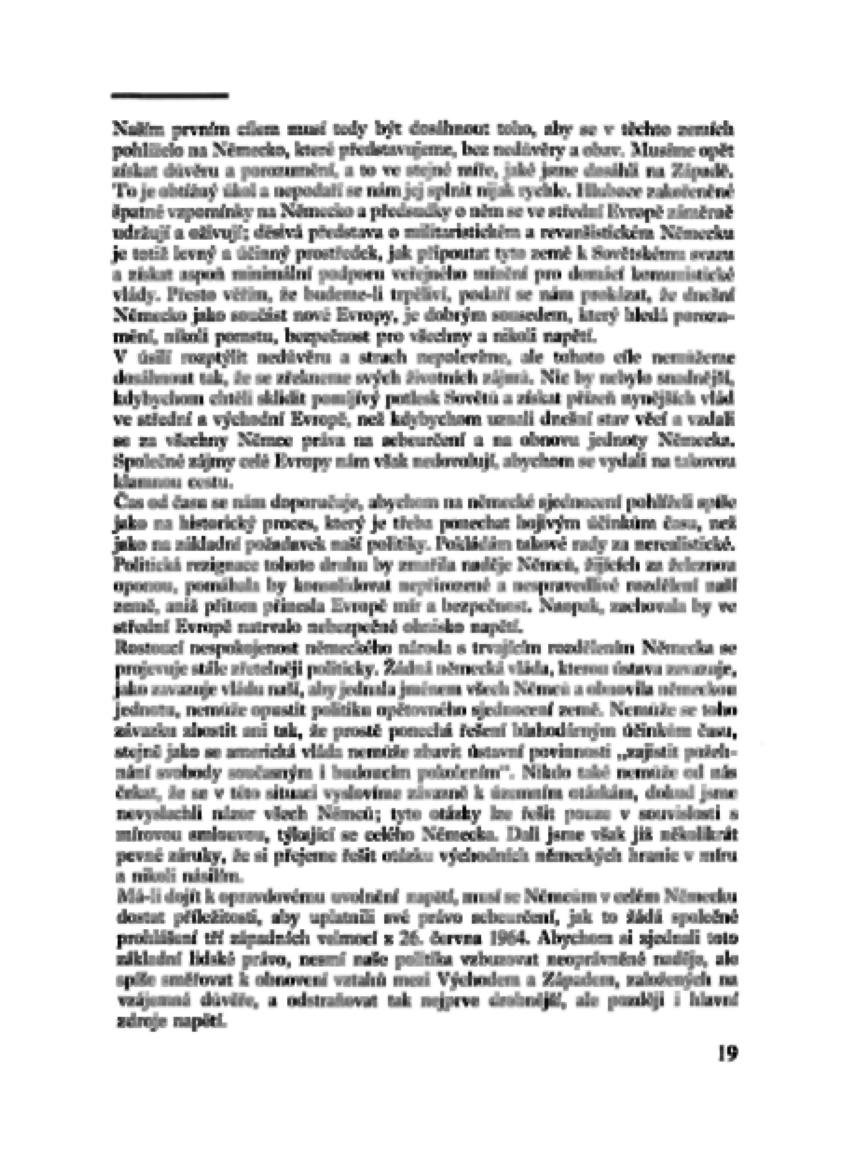

In [9]:
kernel = np.ones((2, 2), np.uint8)
np_array_corrected = cv2.erode(np_array, kernel, iterations=1)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array_corrected)
ax.set_axis_off()
print(pytesseract.image_to_string(np_array_corrected, lang="ces"))

Naším prvním cem muné tedy byt dosáhnout toho, sby se v těchto zemích
pohlício na Německo, ktré představujeme, bez nedůvěry a obav; Musíme opět
aka důvěru a porozumění, čo ve stejné míře, jké jeme dosáhli na Západě,
"Toje obtížný úkol s nepodaří se nám jej plnit nk rychle, Hlboce zakořeněné
špatné vzpomínky na Německo  předsadky o něm se ve střední Bropě záměrně
držjí oživují; děsivá představa 0 mirariickém a rovonšsském Německu
je tož levný a účšaný prostředek, jk připoutat yo země k Sovětskému sv
(získat apod minimální podporu vetjného mínění pro domácí komunitické
lády, Přeno věřím, že budeme-li trpěliví, podaří se nám prokázat, že dnešní
Námecko jako součist nové Evropy, j dobrým sousedem, který ledě poru
mění, nikoli pomotu, bezpečnost ro všehny 3 náol napětí.
Ví rozpustí nedůvěm a strach oepolevime, le tohoto cíle nemůžeme
Sosáhnout ak, že e řekneme ových Jivotich zájmů: Nic by nebylo snadněji
kdybychom shui sklidit pomívý norka Sovětů získat přízeň nynějších vlád
Ve střední a vý

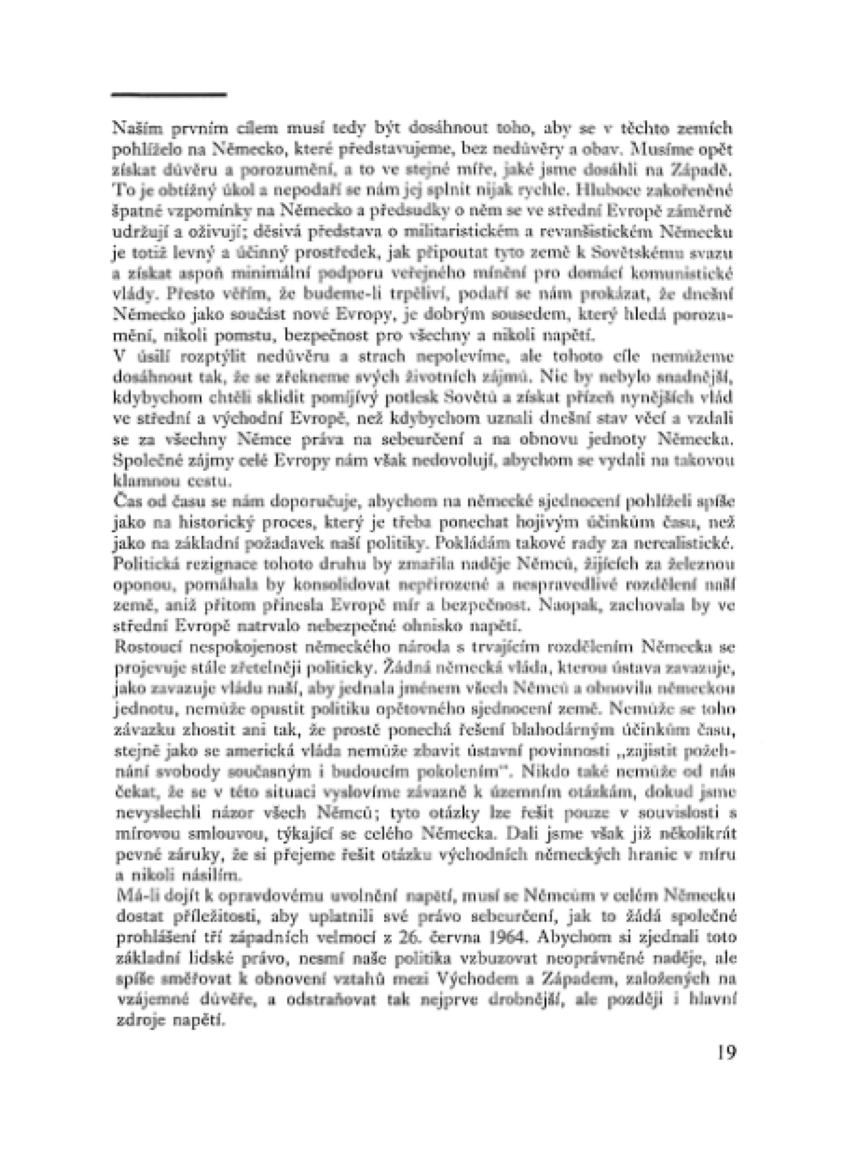

In [10]:
# DILATION
kernel = np.ones((1, 1), np.uint8)
np_array_corrected = cv2.dilate(np_array, kernel, iterations=1)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array_corrected)
ax.set_axis_off()
print(pytesseract.image_to_string(np_array_corrected, lang="ces"))

Naším prvním cem muné tedy byt dosáhnout toho, sby se v těchto zemích
pohlício na Německo, ktré představujeme, bez nedůvěry a obav; Musíme opět
aka důvěru a porozumění, čo ve stejné míře, jké jeme dosáhli na Západě,
"Toje obtížný úkol s nepodaří se nám jej plnit nk rychle, Hlboce zakořeněné
špatné vzpomínky na Německo  předsadky o něm se ve střední Bropě záměrně
držjí oživují; děsivá představa 0 mirariickém a rovonšsském Německu
je tož levný a účšaný prostředek, jk připoutat yo země k Sovětskému sv
(získat apod minimální podporu vetjného mínění pro domácí komunitické
lády, Přeno věřím, že budeme-li trpěliví, podaří se nám prokázat, že dnešní
Námecko jako součist nové Evropy, j dobrým sousedem, který ledě poru
mění, nikoli pomotu, bezpečnost ro všehny 3 náol napětí.
Ví rozpustí nedůvěm a strach oepolevime, le tohoto cíle nemůžeme
Sosáhnout ak, že e řekneme ových Jivotich zájmů: Nic by nebylo snadněji
kdybychom shui sklidit pomívý norka Sovětů získat přízeň nynějších vlád
Ve střední a vý

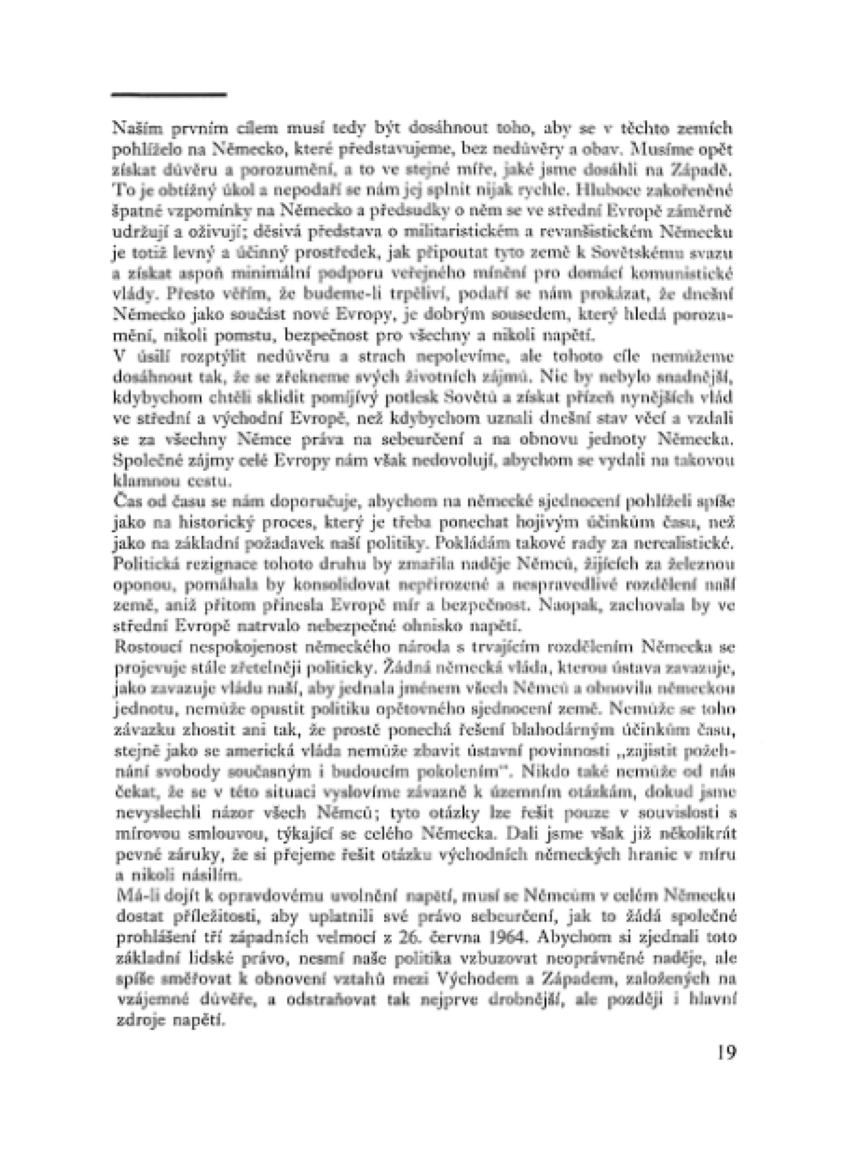

In [11]:

# EROSION
kernel = np.ones((1, 1), np.uint8)
np_array_corrected = cv2.erode(np_array, kernel, iterations=1)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array_corrected)
ax.set_axis_off()
print(pytesseract.image_to_string(np_array_corrected, lang="ces"))

Naším prvním cem muné tedy byt dosáhnout toho, sby se v těchto zemích
pohlício na Německo, ktré představujeme, bez nedůvěry a obav; Musíme opět
aka důvěru a porozumění, čo ve stejné míře, jké jeme dosáhli na Západě,
"Toje obtížný úkol s nepodaří se nám jej plnit nk rychle, Hlboce zakořeněné
špatné vzpomínky na Německo  předsadky o něm se ve střední Bropě záměrně
držjí oživují; děsivá představa 0 mirariickém a rovonšsském Německu
je tož levný a účšaný prostředek, jk připoutat yo země k Sovětskému sv
(získat apod minimální podporu vetjného mínění pro domácí komunitické
lády, Přeno věřím, že budeme-li trpěliví, podaří se nám prokázat, že dnešní
Námecko jako součist nové Evropy, j dobrým sousedem, který ledě poru
mění, nikoli pomotu, bezpečnost ro všehny 3 náol napětí.
Ví rozpustí nedůvěm a strach oepolevime, le tohoto cíle nemůžeme
Sosáhnout ak, že e řekneme ových Jivotich zájmů: Nic by nebylo snadněji
kdybychom shui sklidit pomívý norka Sovětů získat přízeň nynějších vlád
Ve střední a vý

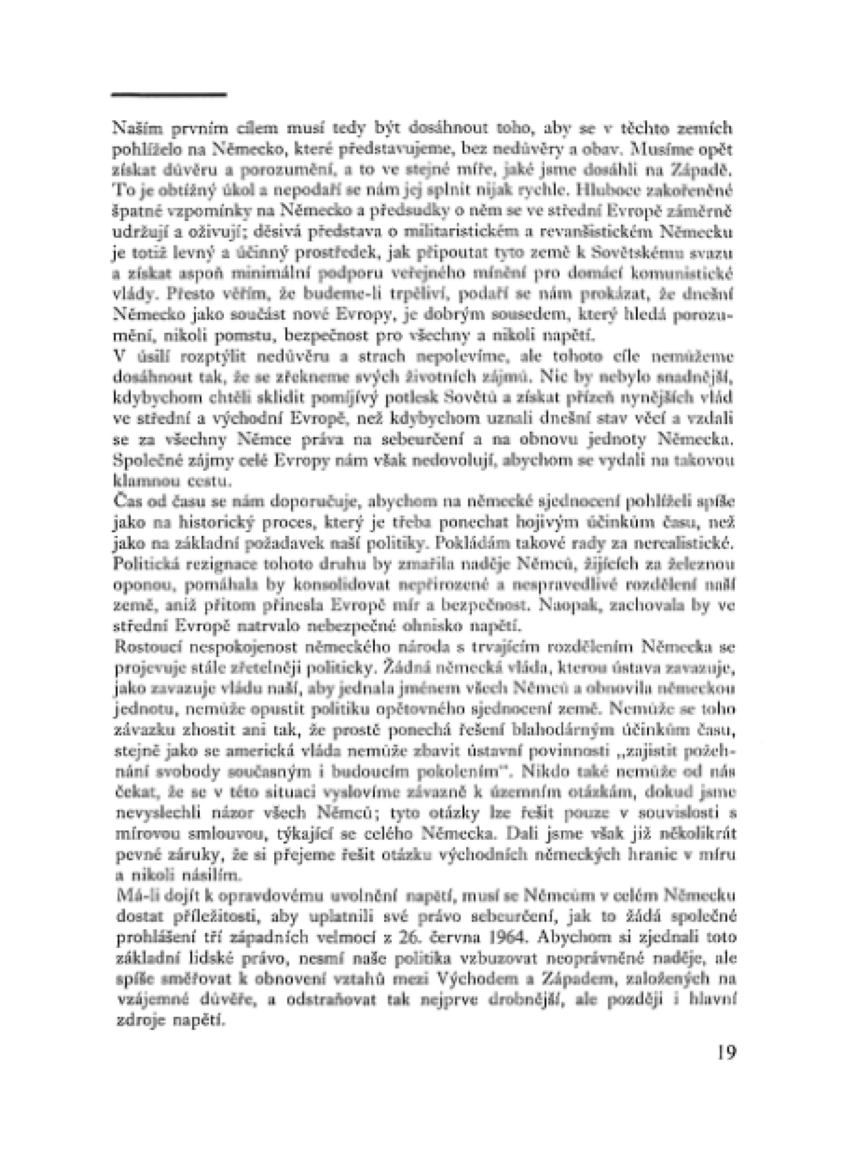

In [12]:

# CLOSING
kernel = np.ones((1, 1), np.uint8)
np_array_corrected = cv2.morphologyEx(np_array, cv2.MORPH_CLOSE, kernel)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array_corrected)
ax.set_axis_off()
print(pytesseract.image_to_string(np_array_corrected, lang="ces"))

Naším prvním cem muné tedy byt dosáhnout toho, sby se v těchto zemích
pohlício na Německo, ktré představujeme, bez nedůvěry a obav; Musíme opět
aka důvěru a porozumění, čo ve stejné míře, jké jeme dosáhli na Západě,
"Toje obtížný úkol s nepodaří se nám jej plnit nk rychle, Hlboce zakořeněné
špatné vzpomínky na Německo  předsadky o něm se ve střední Bropě záměrně
držjí oživují; děsivá představa 0 mirariickém a rovonšsském Německu
je tož levný a účšaný prostředek, jk připoutat yo země k Sovětskému sv
(získat apod minimální podporu vetjného mínění pro domácí komunitické
lády, Přeno věřím, že budeme-li trpěliví, podaří se nám prokázat, že dnešní
Námecko jako součist nové Evropy, j dobrým sousedem, který ledě poru
mění, nikoli pomotu, bezpečnost ro všehny 3 náol napětí.
Ví rozpustí nedůvěm a strach oepolevime, le tohoto cíle nemůžeme
Sosáhnout ak, že e řekneme ových Jivotich zájmů: Nic by nebylo snadněji
kdybychom shui sklidit pomívý norka Sovětů získat přízeň nynějších vlád
Ve střední a vý

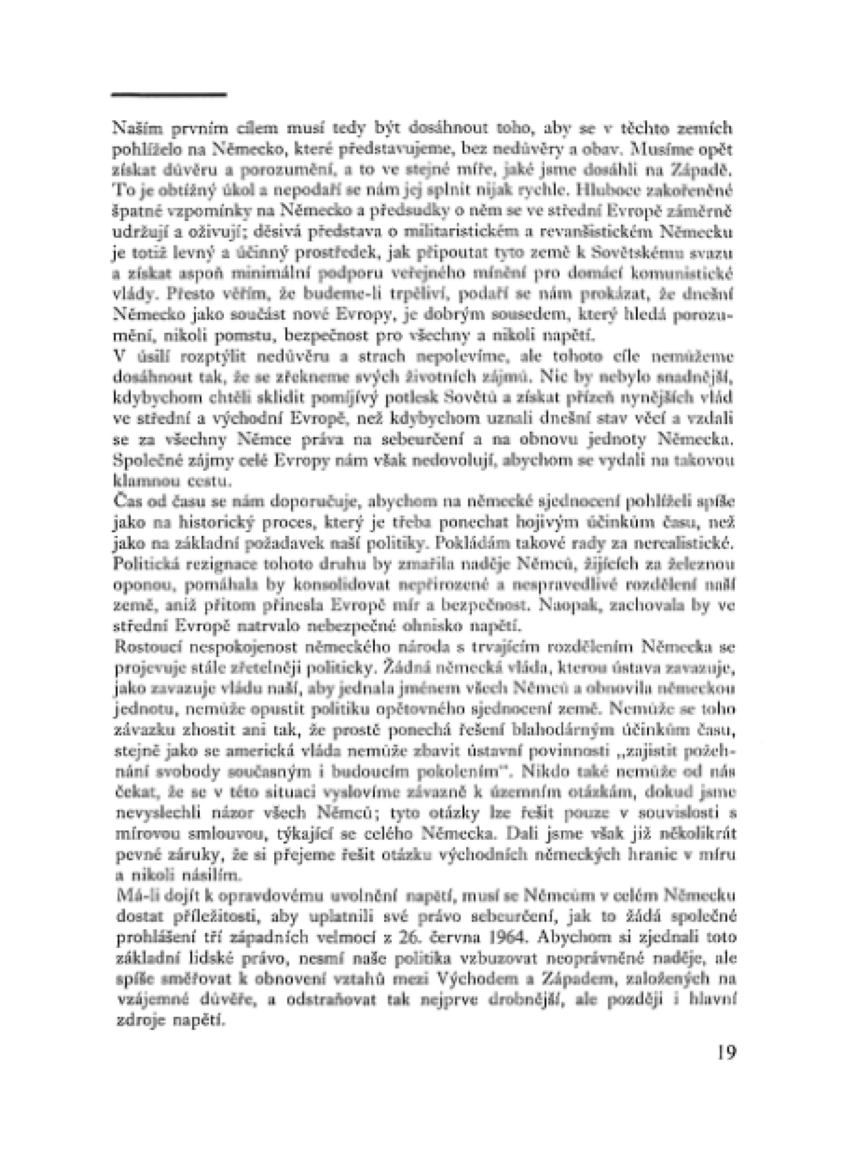

In [13]:
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(np_array, cv2.MORPH_OPEN, kernel)
np_array_corrected = cv2.morphologyEx(np_array, cv2.MORPH_CLOSE, kernel)
fig, ax = plt.subplots(dpi=300)
ax.imshow(np_array_corrected)
ax.set_axis_off()
print(pytesseract.image_to_string(np_array_corrected, lang="ces"))